<a href="https://colab.research.google.com/github/DanielhCarranza/Machine-Learning-in-Health/blob/master/Nucleus_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nucleus Segmentation 

## Spot Nuclei -> Speed Cures
Imagine speeding up research for almost every disease, from lung cancer and heart disease to rare disorders. 

We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. Think how many lives would be transformed if cures came faster.

By automating nucleus detection, you could help unlock cures faster—from rare disorders to the common cold. 

![texto alternativo](https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg)



## Data Description
This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence). The dataset is designed to challenge an algorithm's ability to generalize across these variations.

Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders:

images contains the image file.
masks contains the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).
The second stage dataset will contain images from unseen experimental conditions. To deter hand labeling, it will also contain images that are ignored in scoring. The metric used to score this competition requires that your submissions are in run-length encoded format. Please see the evaluation page for details.

As with any human-annotated dataset, you may find various forms of errors in the data. You may manually correct errors you find in the training set. The dataset will not be updated/re-released unless it is determined that there are a large number of systematic errors. The masks of the stage 1 test set will be released with the release of the stage 2 test set.


### References:
* [Nucleus segmentation across imaging experiments: the 2018 Data Science Bowl](nature.com/articles/s41592-019-0612-7) --> [Code](https://github.com/carpenterlab/2019_caicedo_dsb)

### Setup 

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ingbiodanielh","key":"42c086b139c8c921f1285d422d295137"}'}

In [ ]:
# upload your kaggle json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

# Download data
! kaggle competitions download -c data-science-bowl-2018

# train data
! mkdir Nucleus_data
! unzip stage1_train.zip -d Nucleus_data 
! unzip stage1_train_labels.csv.zip

# test 
! mkdir test_data
! unzip stage1_test.zip -d test_data

In [ ]:
! pip install git+https://github.com/fastai/fastai.git

#### GCP


In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'project'
bucket_name='datasets'


!gcloud config set project {project_idJL}

In [ ]:
def ls_gcp(path):
  ! gsutil ls gs://{path}

def upload_files_to_gcp(local_path, bucket_path):
  ! gsutil -m cp -r {local_path} gs://{bucket_path}

def download_files_from_gcp(bucket_path, local_path):
#   if not os.path.isdir(local_path): os.mkdir(local_path)
  ! gsutil -m cp -r gs://{bucket_path} {local_path} 

# Nucleus Segmentation with Pytorch

### Modules

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage.io as sk

from fastai import *
from fastai.vision import * 

from torch.utils import data
from torchvision import transforms 
from torch.utils.data import DataLoader, Dataset


In [ ]:
path= Path('data/')

In [ ]:
train_paths= Path('data/').glob('*/images/*.png')
mask_paths= Path('data/').glob('*/masks/')

In [ ]:
train_files= [i for i in train_paths]
masks_files= [i for i in mask_paths]

## Nucleus Dataset

In [ ]:
class NucleusDataset(Dataset):
  
  def __init__(self, image_files, masks_files, tfms_X=None, tfms_y=None ):
    self.image_files=image_files
    self.masks_files=masks_files
    self.tfms_X = tfms_X
    self.tfms_y = tfms_y
    self.images = self.load_images()
    self.masks  = self.load_masks()
    
    
  def __getitem__(self, index):

    get_id= lambda x: str(x).split('/')[1] 
    list_id= {idx: get_id(f) for idx, f in enumerate(self.image_files)}
    
    if self.tfms_X and self.tfms_y:
      image= self.tfms_X(self.images[list_id[index]])
      mask = self.tfms_y(self.masks[list_id[index]])
    
    else: 
      image= PIL.Image.fromarray(self.images[list_id[index]]).convert('RGB')
      mask = PIL.Image.fromarray(self.masks[list_id[index]])
       
    return image, mask 
  
  def __len__(self):
    return len(self.images)
  
  
  def load_images(self):
    images={}    
    for img_file in tqdm(self.image_files):
      image_id = str(img_file).split('/')[1]
      img = sk.imread(img_file)
      images[image_id] = img[:,:,:3]
    return images
  
  def load_masks(self):
    masks={}
    for f in tqdm(self.masks_files):
      image_id=str(f).split('/')[1]
      mask=sk.imread_collection(str(f/'*.png')).concatenate()
  
      num_masks = mask.shape[0]
      _,H,W = mask.shape
      labels = np.zeros((H, W), np.uint8)
      for index in range(0, num_masks):
          labels[mask[index] > 0] =  1 
      masks[image_id]= labels
    return masks
  

In [ ]:
image_files= Path('data/').glob('*/images/*.png')
mask_paths= Path('data/').glob('*/masks/')

train_files= [i for i in image_files]
masks_files= [i for i in mask_paths]


In [ ]:
tfms_X= transforms.Compose([transforms.ToPILImage(),
                          transforms.Resize((256,256)),
                          transforms.ToTensor()])

tfms_y= transforms.Compose([transforms.ToPILImage(),
                          transforms.Resize((256,256), interpolation=PIL.Image.NEAREST),
                          transforms.ToTensor()])
        

In [ ]:
%%time
data= NucleusDataset(train_files, masks_files, tfms_X, tfms_y)

100%|██████████| 670/670 [00:47<00:00, 14.08it/s]

CPU times: user 47.8 s, sys: 4.5 s, total: 52.3 s
Wall time: 52.3 s


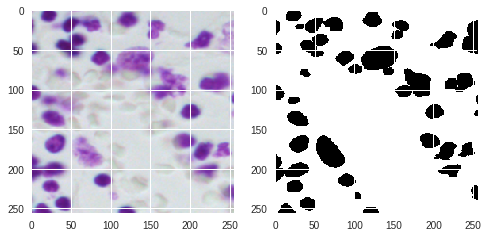

In [ ]:
im, m= data[70]

plt.subplot(121)
plt.imshow(im.numpy().T)
plt.subplot(122)
plt.imshow(np.squeeze(m.numpy().T))

In [ ]:
dl= DataLoader(data, batch_size=4, num_workers=4)


## U-Net Model

In [ ]:
from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.sigmoid(x)
        return x

### Soft Dice Loss Function

In [ ]:
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

### Training

In [ ]:
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

for epoch in range(2):
    for x_train, y_train  in tqdm(dl):
        x_train = torch.autograd.Variable(x_train).cuda()
        y_train = torch.autograd.Variable(y_train).cuda()
        optimizer.zero_grad()
        o = model(x_train)
        loss = soft_dice_loss(o, y_train)
        loss.backward()
        optimizer.step()


  0%|          | 0/168 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
100%|██████████| 168/168 [01:51<00:00,  1.52it/s]


In [ ]:
loss

tensor(0.9925, device='cuda:0', grad_fn=<RsubBackward1>)

## Test 

In [ ]:
test_path=Path('test_data/')

In [ ]:
class NucleusTestDataset():
    def __init__(self,path, tfms, suffix='.png' ):
        self.test_files=[file for file in path.glob(f'**/*{suffix}')]
        self.tfms=tfms
        
    def __getitem__(self, index):
        
        self.test_images=[sk.imread(f) for f in test_files]

        if self.tfms:
          return self.tfms(self.test_images[index][:,:,:3])
        
        else:
          return self.test_images[index]
          
          
    def __len__(self):
        return len(self.test_files)


In [ ]:
test_tfms= transforms.Compose([transforms.ToPILImage(),
                          transforms.Resize((256,256)),
                          transforms.ToTensor()])
testset = NucleusTestDataset(test_path, test_tfms)
testdataloader = DataLoader(testset,num_workers=2,batch_size=2)

In [ ]:
model = model.eval()
for data in testdataloader:
    data = torch.autograd.Variable(data, volatile=True).cuda()
    o = model(data)
    break

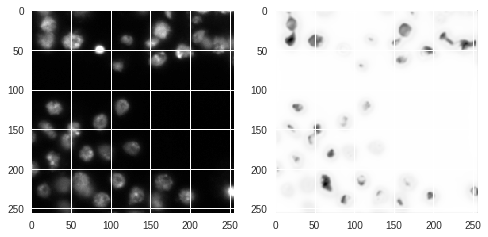

In [ ]:
tm=o[1][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[1].data.cpu().permute(1,2,0).numpy())
plt.subplot(122)
plt.imshow(tm)

# Mask RCNN

#### Setup

In [ ]:
! git clone https://github.com/matterport/Mask_RCNN.git
! wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/mask_rcnn_balloon.h5

In [ ]:
cd Mask_RCNN


/content/Mask_RCNN


In [ ]:
! pip3 install -r requirements.txt
! python3 setup.py install


In [ ]:
! mkdir datasets
! mkdir datasets/nucleus

In [ ]:
cd ..

/content


In [ ]:
# upload your kaggle json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

# Download data
! kaggle competitions download -c data-science-bowl-2018



  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 4.81MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.6MB/s]
 55% 5.00M/9.10M [00:00<00:00, 34.4MB/s]
100% 9.10M/9.10M [00:00<00:00, 44.5MB/s]
 87% 69.0M/79.1M [00:00<00:00, 80.1MB/s]
100% 79.1M/79.1M [00:00<00:00, 125MB/s] 
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 106MB/s]
 96% 265M/276M [00:01<00:00, 179MB/s]
100% 276M/276M [00:01<00:00, 159MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 54.1MB/s]


In [ ]:
# train data
! mkdir Mask_RCNN/datasets/nucleus/stage1_train
! unzip stage1_train.zip -d Mask_RCNN/datasets/nucleus/stage1_train 
# ! unzip stage1_train_labels.csv.zip

# test 
! mkdir test_data
! unzip stage1_test.zip -d test_data

In [ ]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

In [ ]:
cd Mask_RCNN/samples/nucleus

/content/Mask_RCNN/samples/nucleus


In [ ]:

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/nucleus"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))
    
# Import Mask RCNN
sys.path.append(ROOT_DIR)

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import nucleus

Using TensorFlow backend.


In [ ]:
cd ../..

/content/Mask_RCNN


In [ ]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/nucleus/")

# Use configuation from nucleus.py, but override
# image resizing so we see the real sizes here
class NoResizeConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
dataset = nucleus.NucleusDataset()

In [ ]:
dataset.load_nucleus('datasets/nucleus/', subset="train")

In [ ]:
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 645
Class Count: 2
  0. BG                                                
  1. nucleus                                           


In [ ]:
dataset

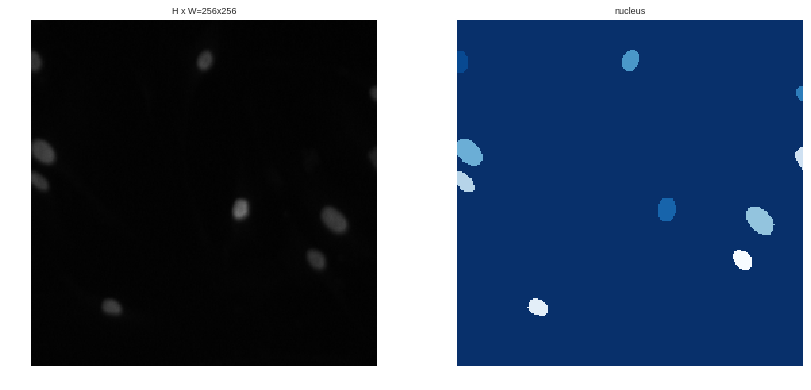

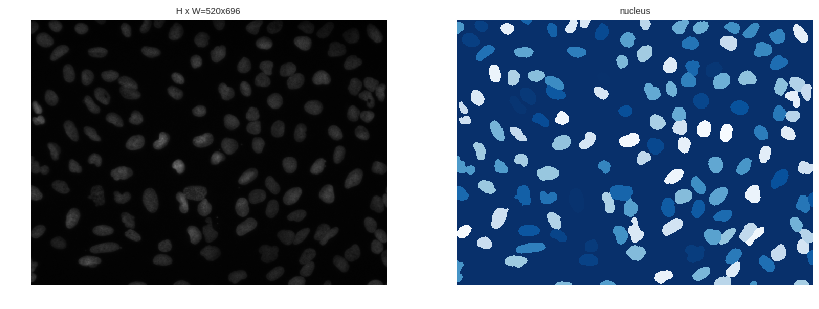

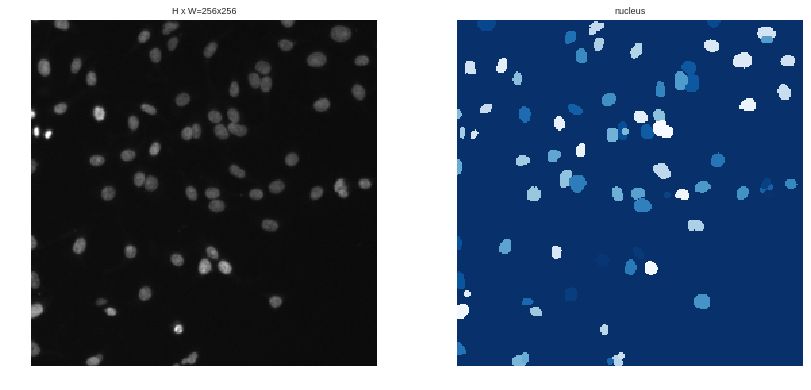

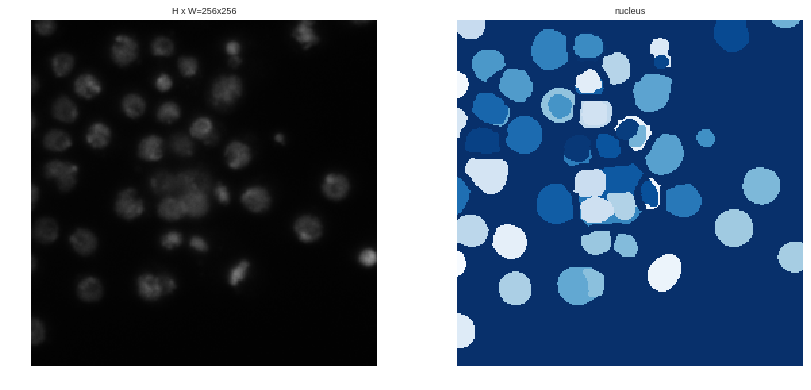

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

molded_image             shape: (256, 320, 3)         min:   28.00000  max:  232.00000  uint8
mask                     shape: (256, 320, 42)        min:    0.00000  max:    1.00000  bool


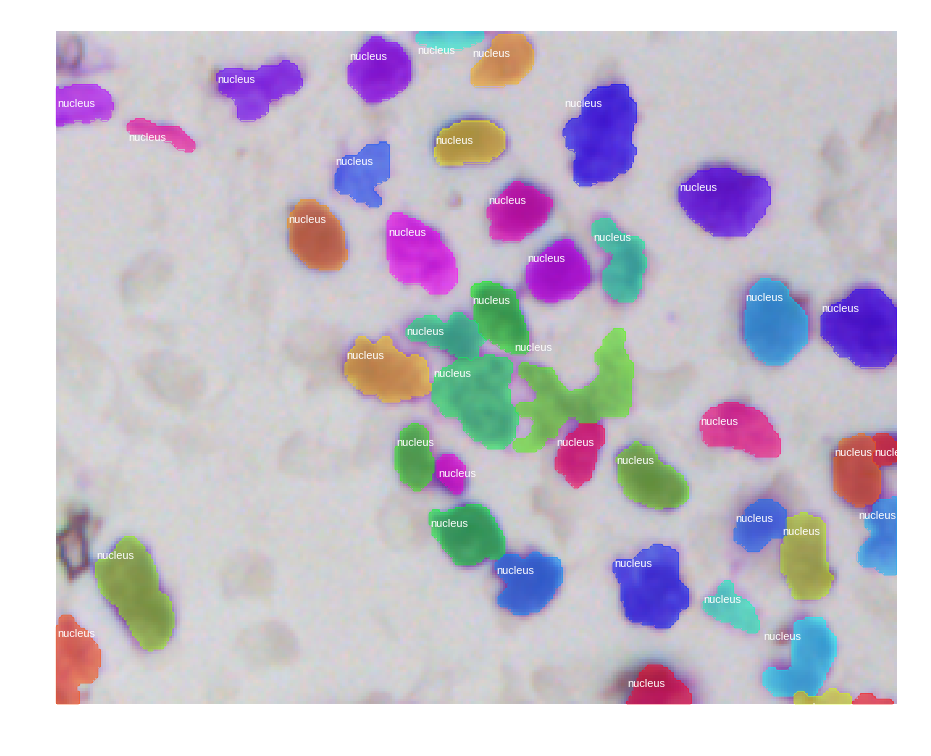

In [ ]:

# Example of loading a specific image by its source ID
source_id = "ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279"

# Map source ID to Dataset image_id
# Notice the nucleus prefix: it's the name given to the dataset in NucleusDataset
image_id = dataset.image_from_source_map["nucleus.{}".format(source_id)]

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False)

In [ ]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

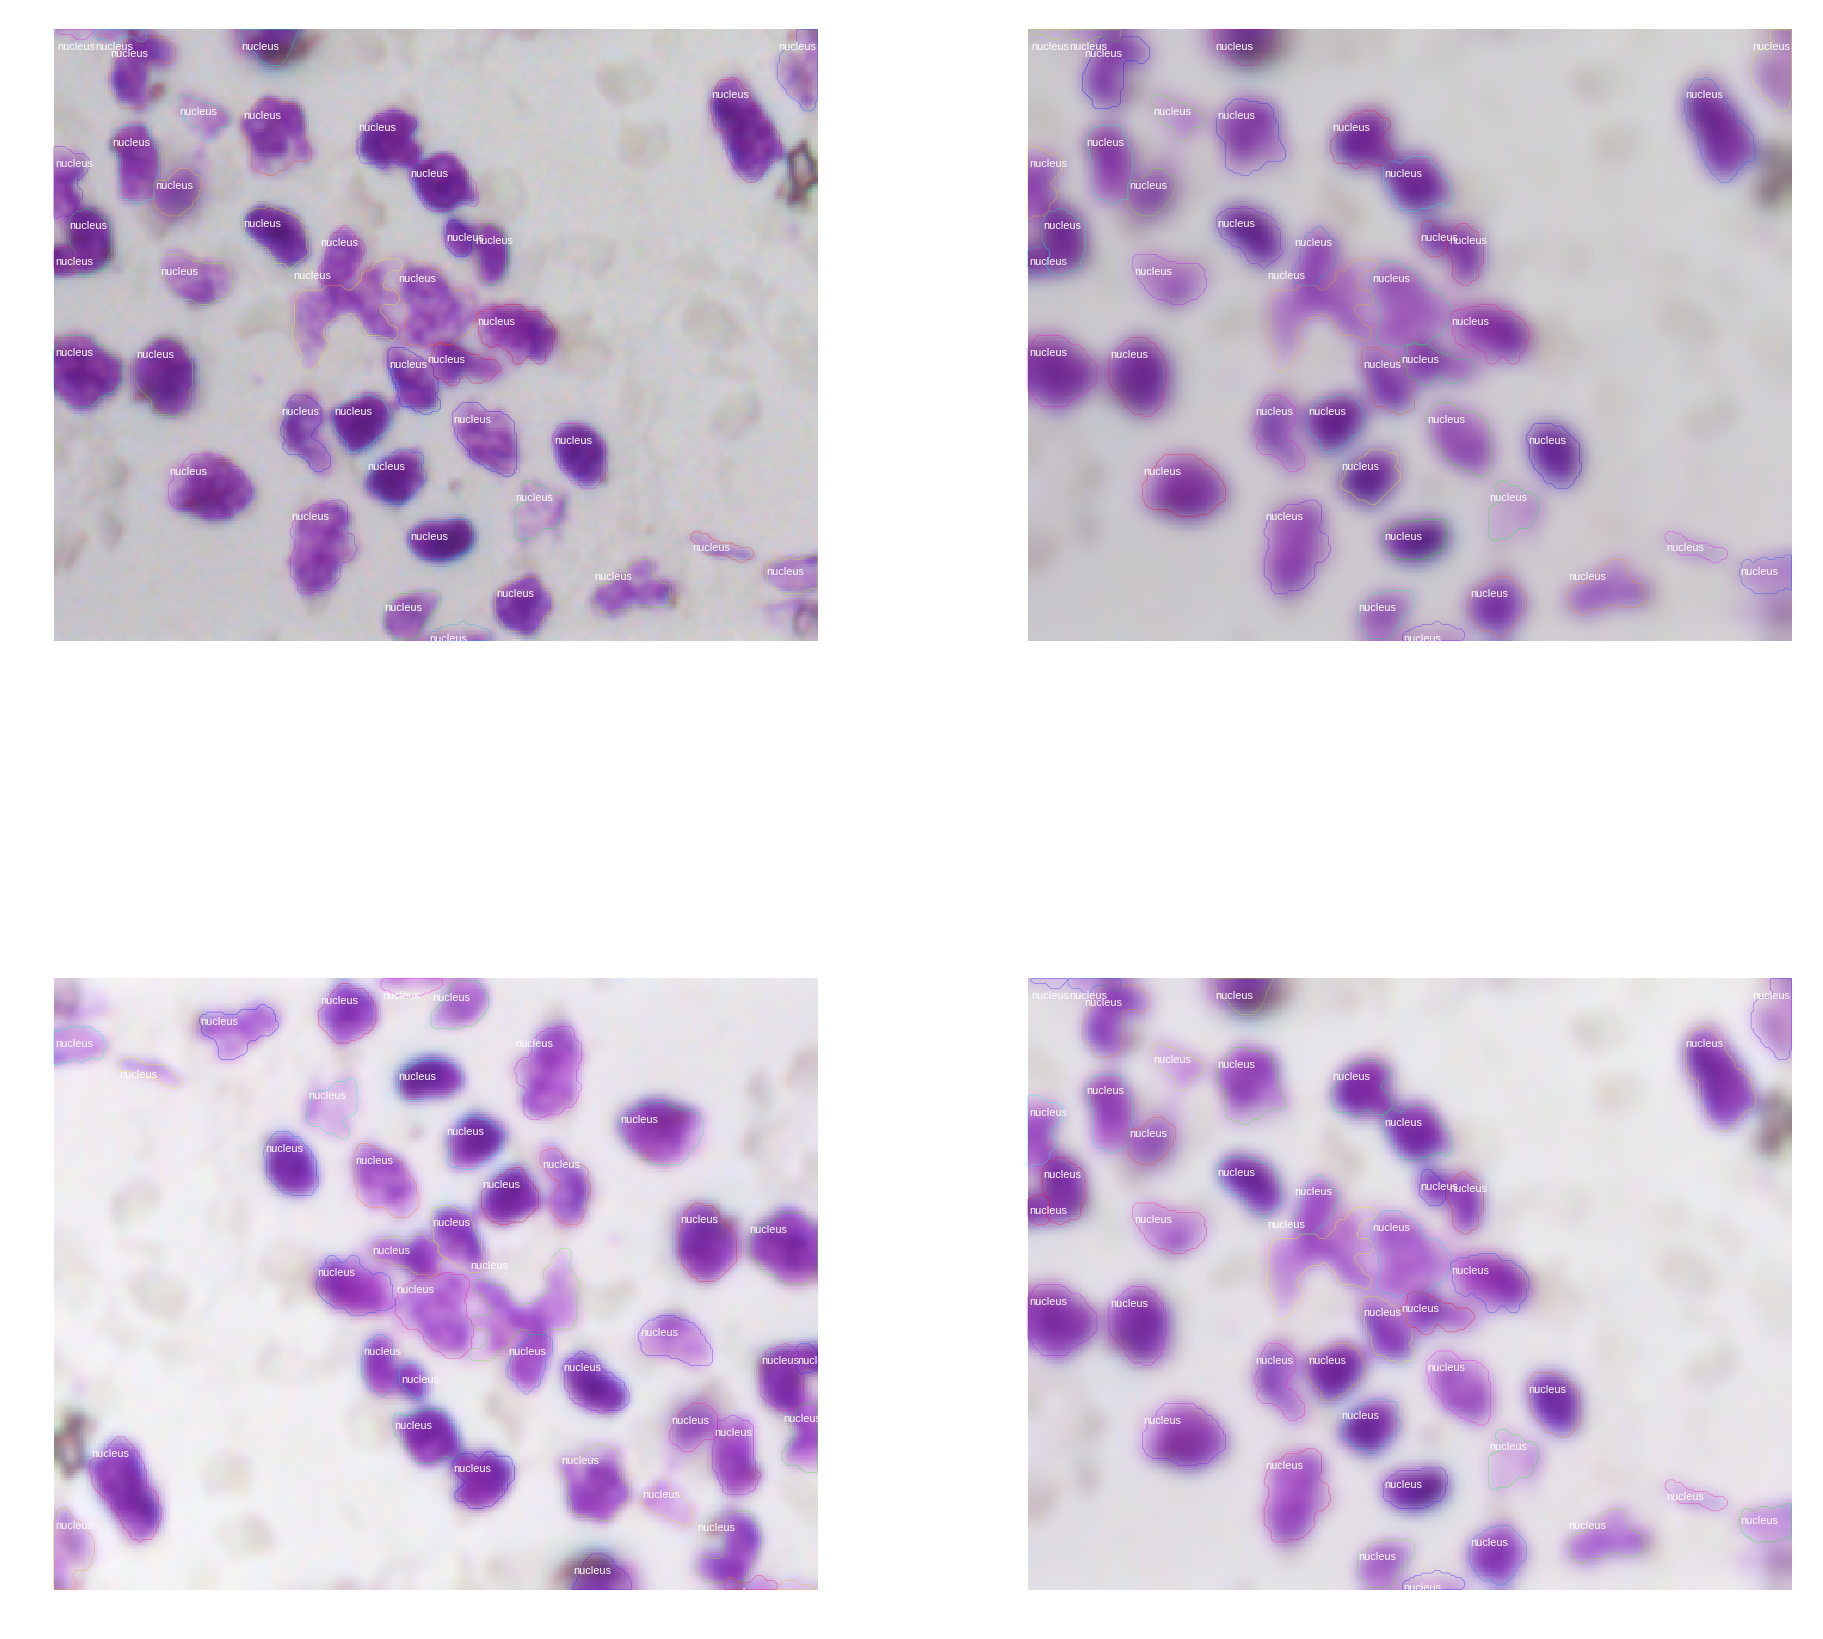

In [ ]:
# Load the image multiple times to show augmentations
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

In [ ]:
class RandomCropConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

crop_config = RandomCropConfig()

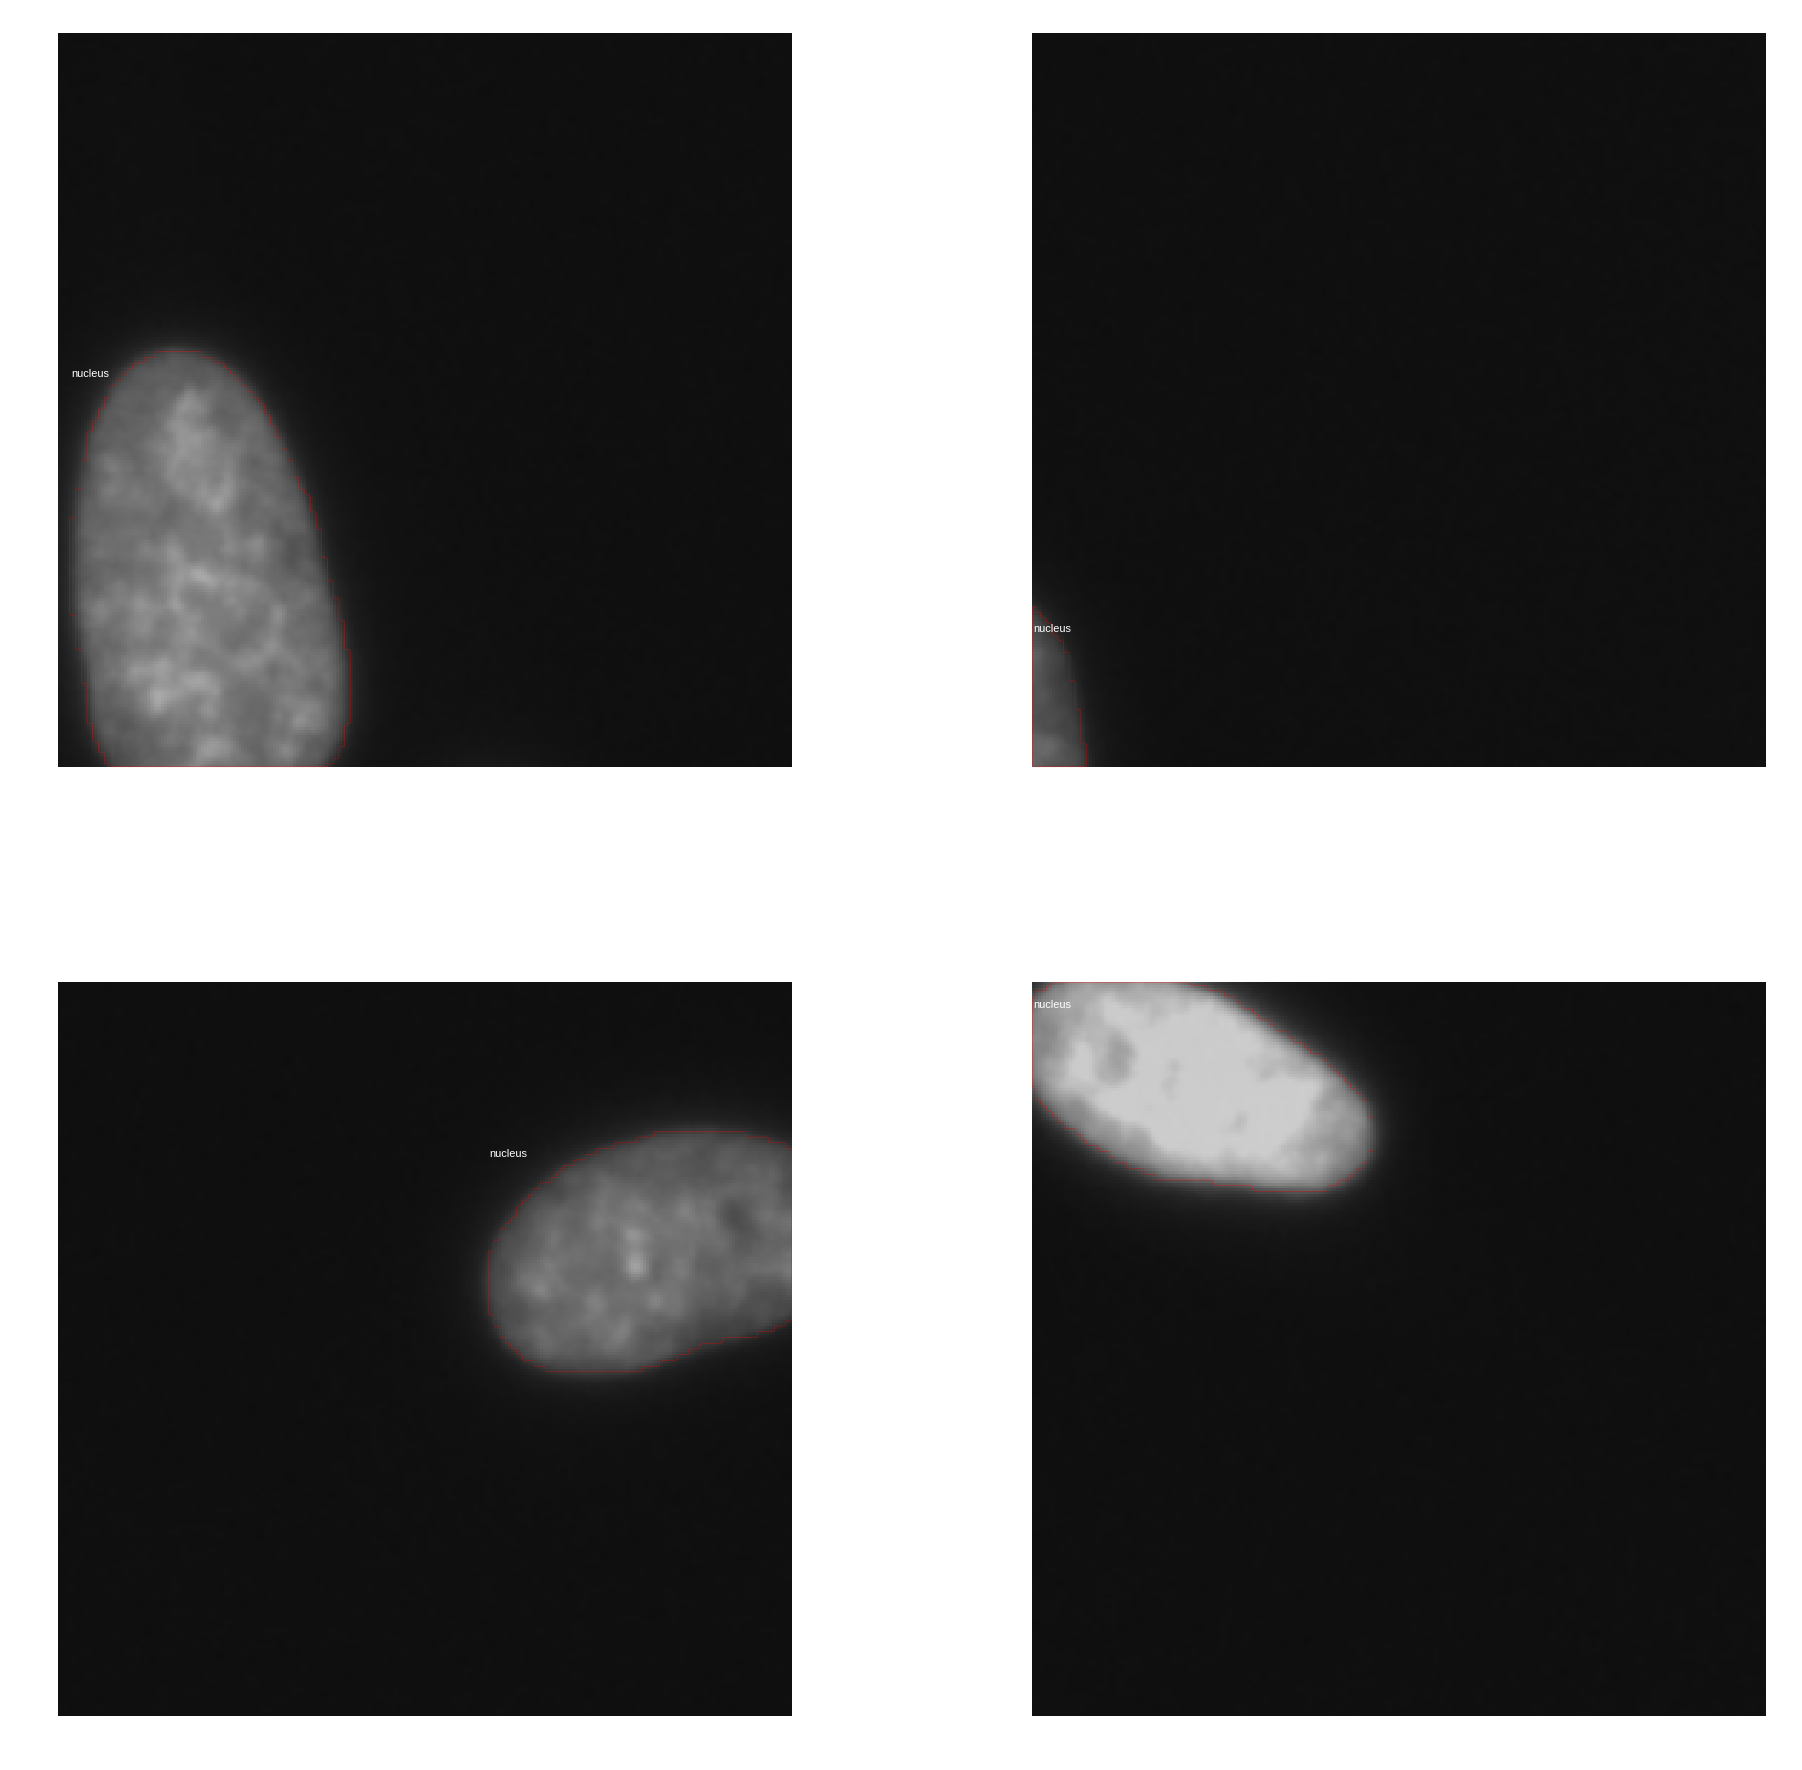

In [ ]:

# Load the image multiple times to show augmentations
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, crop_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Model 

In [ ]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/nucleus/")

# Inference Configuration
config = nucleus.NucleusInferenceConfig()
config.display()

In [ ]:
DEVICE = "/gpu:0"

TEST_MODE = "inference"

In [ ]:
dataset = nucleus.NucleusDataset()
dataset.load_nucleus(DATASET_DIR, "train")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 645
Classes: ['BG', 'nucleus']


In [ ]:
configT= nucleus.NucleusConfig()
configT.LEARNING_RATE= 0.001

In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="training",
                              model_dir=LOGS_DIR,
                              config=configT)

In [ ]:
def train(model, dataset_dir, subset):
    """Train the model."""
    # Training dataset.
    dataset_train = nucleus.NucleusDataset()
    dataset_train.load_nucleus(dataset_dir, subset)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = nucleus.NucleusDataset()
    dataset_val.load_nucleus(dataset_dir, "val")
    dataset_val.prepare()

    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

    # *** This training schedule is an example. Update to your needs ***

    # If starting from imagenet, train heads only for a bit
    # since they have random weights
    print("Train network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,
                augmentation=augmentation,
                layers='heads')

    print("Train all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=40,
                augmentation=augmentation,
                layers='all')

In [ ]:
train(model, DATASET_DIR, 'train')

Train network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/nucleus20190321T0618/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
105/105 [==============================] - 1285s 12s/step - loss: 4.2277 - rpn_class_loss: 0.6874 - rpn_bbox_loss: 1.6779 - mrcnn_class_loss: 0.1482 - mrcnn_bbox_loss: 1.0300 - mrcnn_mask_loss: 0.6842 - val_loss: 3.4830 - val_rpn_class_loss: 0.3431 - val_rpn_bbox_loss: 1.3687 - val_mrcnn_class_loss: 0.1542 - val_mrcnn_bbox_loss: 0.9808 - val_mrcnn_mask_loss: 0.6361
Epoch 2/20
 31/105 [=======>......................] - ETA: 5:46 - loss: 3.3593 - rpn_class_loss: 0.3362 - rpn_bbox_loss: 1.3648 - mrcnn_class_loss: 0.1972 - mrcnn_bbox_loss: 0.8306 - mrcnn_mask_loss: 0.6305

In [ ]:
! python3 nucleus.py train --dataset=/path/to/dataset --subset=train --weights=imagenet

# FastAI

In [ ]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
# from fastai.vision.interpret import SegmentationInterpretation

import os
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc,roc_curve
from sklearn.metrics import classification_report

In [ ]:
path=Path('Nucleus_data')


In [ ]:
def open_mk(fn:PathOrStr, div:bool=False, convert_mode:str='L', cls:type=ImageSegment,
    after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    #get_labels=lambda x: x.parent.parent/f'masks/'
    mask_files= get_image_files(fn)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        masks=[]
        for file in mask_files:
            x = PIL.Image.open(file).convert('L')
            x = pil2tensor(x,np.float32)
            masks.append(x)
        mask=torch.cat(masks, dim=0)

    if after_open: x = after_open(x)
    num_masks = mask.shape[0]
    _,H,W = mask.shape
    labels = torch.zeros((H, W)) #.type(torch.uint8)
    for index in range(0, num_masks):
      labels[mask[index] > 0] =  1 
    if div: labels.div_(255)
    return cls(labels[None,:,:])

In [ ]:
class NucleusSegmentationLabelList(SegmentationLabelList):
    def open(self,fn): return open_mk(fn)

class NucleusSegmentationItemList(ImageList):
    _label_cls= NucleusSegmentationLabelList 

In [ ]:
get_labels=lambda x: x.parent.parent/f'masks/'

In [ ]:
image_files= path.glob('*/images/*.png')
mask_paths= path.glob('*/masks/')
test_path= (path.parent/'test_data')

train_files= [i for i in image_files]
masks_files= [i for i in mask_paths]

In [ ]:
img_f= train_files[150]
img_f

PosixPath('Nucleus_data/0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426/images/0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426.png')

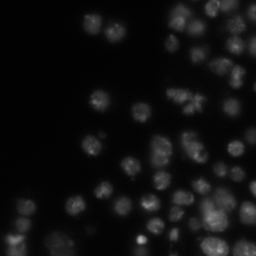

In [ ]:
open_image(img_f)

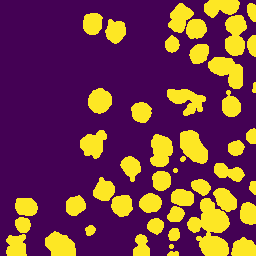

In [ ]:
open_mk(get_labels(img_f))

In [ ]:
files_list=ItemList(train_files)

src=(NucleusSegmentationItemList(files_list)
         .split_by_rand_pct()
         .label_from_func(get_labels,classes=['void','nucleus']))
src

LabelLists;

Train: LabelList (536 items)
x: NucleusSegmentationItemList
Image (3, 256, 256),Image (3, 256, 320),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: NucleusSegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 320),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: .;

Valid: LabelList (134 items)
x: NucleusSegmentationItemList
Image (3, 360, 360),Image (3, 520, 696),Image (3, 520, 696),Image (3, 256, 256),Image (3, 360, 360)
y: NucleusSegmentationLabelList
ImageSegment (1, 360, 360),ImageSegment (1, 520, 696),ImageSegment (1, 520, 696),ImageSegment (1, 256, 256),ImageSegment (1, 360, 360)
Path: .;

Test: None

In [ ]:
def get_data(bs=8, size=(224,224),**kwargs):
    return (src.transform(tfms=get_transforms(flip_vert=True), size=size, tfm_y=True)
            .databunch(bs=bs, num_workers=0, **kwargs)
            .normalize(imagenet_stats))
    

In [ ]:
data= get_data(bs=8, size=224)

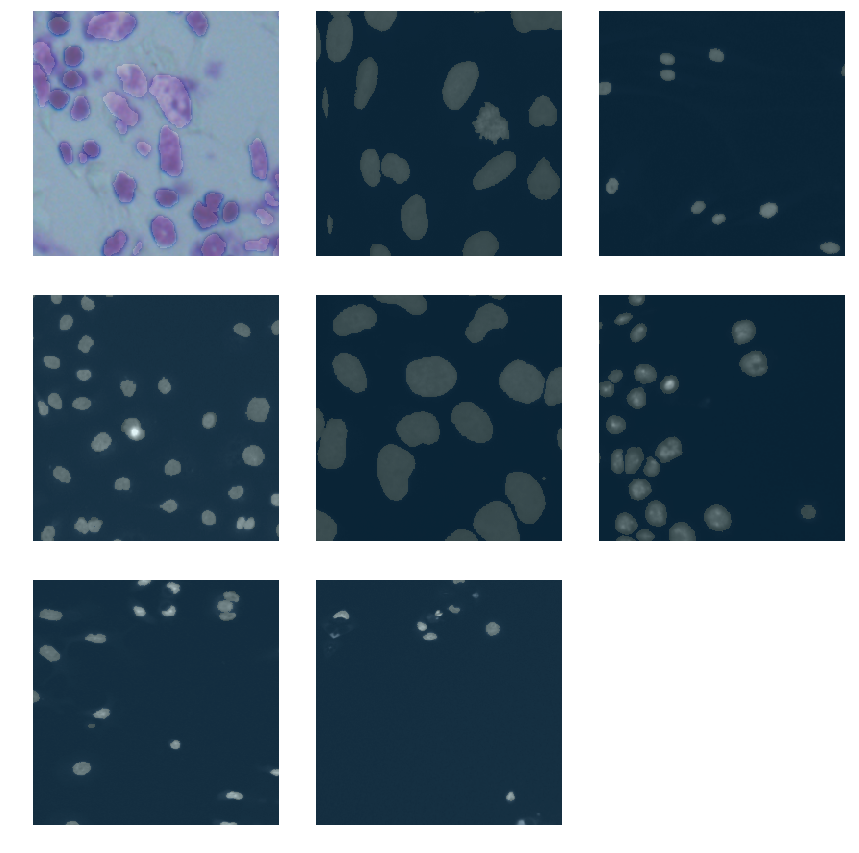

In [ ]:
data.show_batch(rows=3, alpha=0.3)

## Training

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='unet_224'),
        ShowGraph]

In [ ]:
def accuracy_nucleus(input, target):
    target=target.squeeze(1)
    mask =target>0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
learner = unet_learner(data, models.resnet50, metrics=[accuracy_nucleus, dice], callback_fns=cbfs)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


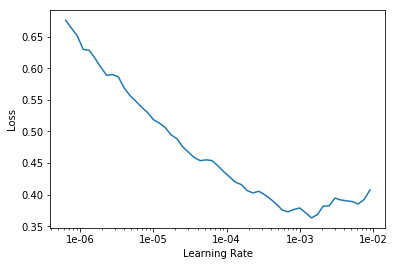

In [ ]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy_nucleus,dice,time
0,0.198422,0.097847,0.859775,0.860430,04:40
1,0.116378,0.074594,0.878213,0.893507,04:38
2,0.099923,0.094451,0.799135,0.860945,04:33
3,0.085828,0.071608,0.847070,0.892366,04:34
4,0.887991,0.310770,0.000246,0.000492,04:31
5,0.698485,0.122221,0.855477,0.843544,04:30
6,0.254495,0.077205,0.905890,0.894555,04:32
7,0.125935,0.092468,0.799030,0.866233,04:30
8,0.086342,0.086446,0.872906,0.891953,04:30
9,0.074418,0.067340,0.906318,0.903690,04:32


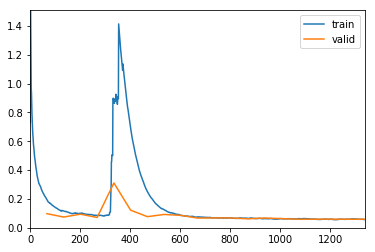

Epoch 2: reducing lr to 0.00010400000000000002
Epoch 4: reducing lr to 0.00018713843876330617
Epoch 5: reducing lr to 0.00020000000000000006
Epoch 6: reducing lr to 0.00019749280124701756
Epoch 7: reducing lr to 0.00019009692640269477
Epoch 8: reducing lr to 0.00017818323551421005
Epoch 10: reducing lr to 0.0001433886003582602
Epoch 11: reducing lr to 0.00012225240438725786
Epoch 13: reducing lr to 7.774839561274217e-05
Epoch 14: reducing lr to 5.661219964173985e-05
Epoch 16: reducing lr to 2.181756448579001e-05
Epoch 17: reducing lr to 9.90387359730526e-06
Epoch 19: reducing lr to 8.000000000000002e-10


In [ ]:
lr= 1e-3
learner.fit_one_cycle(20,max_lr=slice(1e-4, lr), wd=1e-2)

In [ ]:
learner.save('unet_224-91d')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


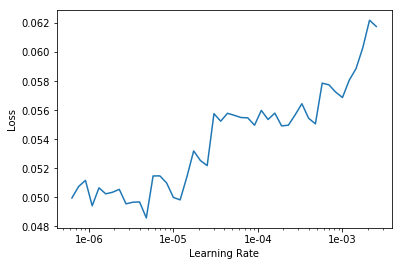

In [ ]:
learner.unfreeze()
learner.to_fp16()
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy_nucleus,dice,time
0,0.057414,0.059558,0.901705,0.912763,03:06
1,0.060030,0.060825,0.893815,0.911565,02:56
2,0.058593,0.058601,0.917331,0.914110,02:57
3,0.060501,0.060265,0.901782,0.910065,02:58
4,0.062093,0.062403,0.914075,0.909736,02:57
5,0.061803,0.076839,0.879607,0.905840,02:55
6,0.061929,0.062944,0.903126,0.911256,02:56
7,0.062648,0.066194,0.858781,0.900760,02:56
8,0.063040,0.066220,0.942102,0.909928,02:57
9,0.059005,0.057556,0.906540,0.914755,02:56


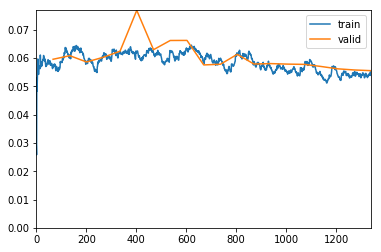

Epoch 1: reducing lr to 2.800000000000001e-05
Epoch 3: reducing lr to 7.6e-05
Epoch 4: reducing lr to 9.356921938165309e-05
Epoch 5: reducing lr to 0.00010000000000000003
Epoch 6: reducing lr to 9.874640062350878e-05
Epoch 7: reducing lr to 9.504846320134738e-05
Epoch 8: reducing lr to 8.909161775710502e-05
Epoch 10: reducing lr to 7.16943001791301e-05
Epoch 11: reducing lr to 6.112620219362893e-05
Epoch 12: reducing lr to 5.000020000000001e-05
Epoch 13: reducing lr to 3.887419780637108e-05
Epoch 14: reducing lr to 2.8306099820869926e-05
Epoch 15: reducing lr to 1.8825834605023703e-05


In [ ]:
lr=1e-3
learner.fit_one_cycle(20, slice(1e-5,lr/2), wd=1e-2)

In [ ]:
learner.save('unet_224-91d-u')

## Evaluation 

In [ ]:
interp = SegmentationInterpretation.from_learner(learner)
top_losses, top_idxs = interp.top_losses(sizes=(224,224))

In [ ]:
learner.data.classes


['void', 'nucleus']

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
void,0.986506
nucleus,0.899843


,label,score
0,void,0.986506
1,nucleus,0.899843


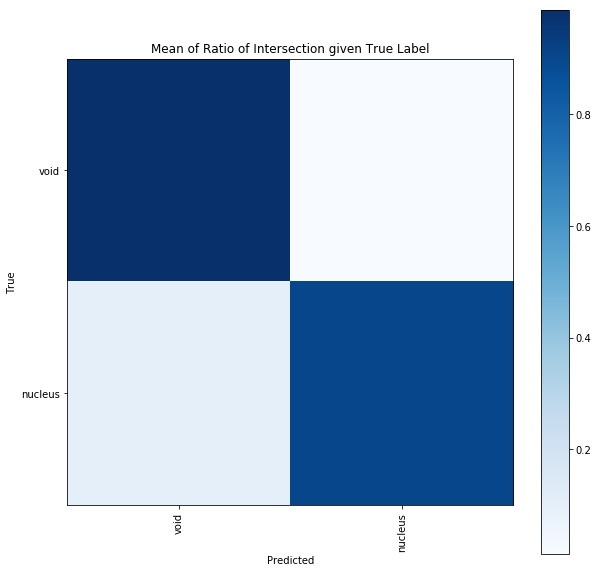

In [ ]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
df

label,score
void,0.925355
nucleus,0.72352


,label,score
0,void,0.925355
1,nucleus,0.72352


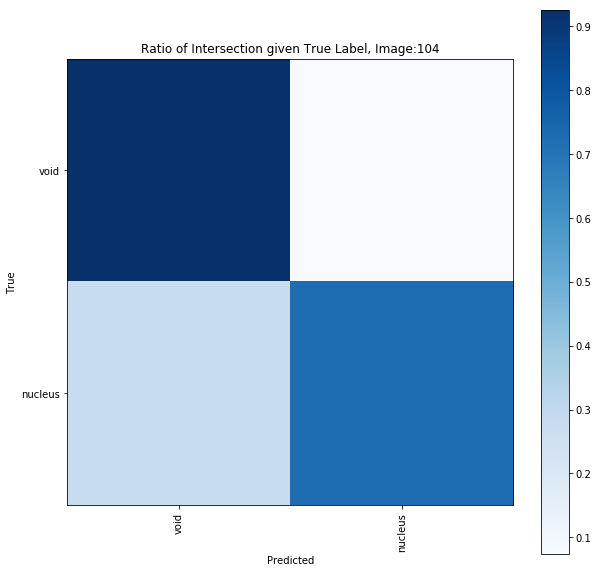

In [ ]:
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
df

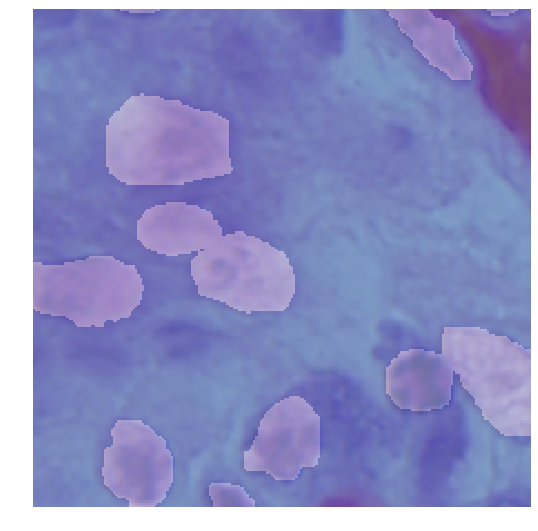

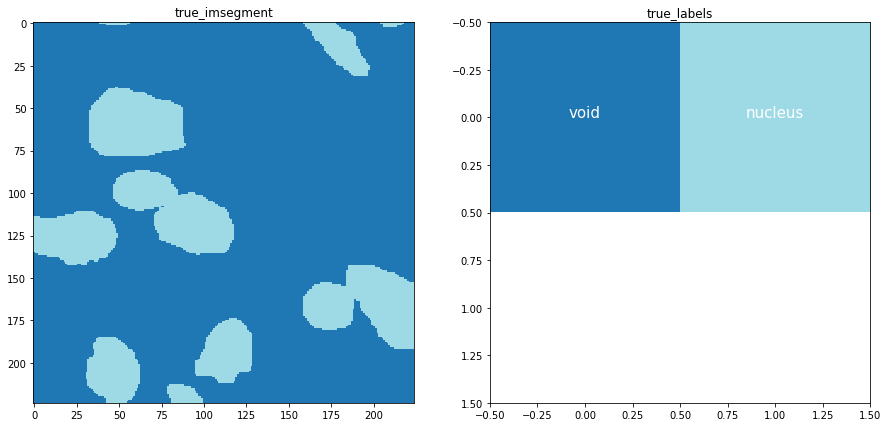

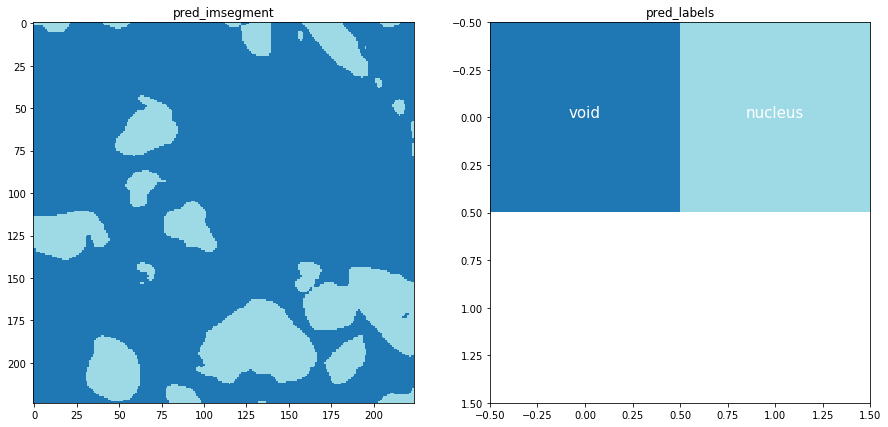

In [ ]:
interp.show_xyz(i, sz=15)

## Inference

In [ ]:
learner.load('unet_224-91d')

In [ ]:
learner.export(file='models/unet_224-91d.pkl')

In [ ]:
model_file= 'unet_224-91d.pkl'
stage_model='unet_224-91d.pth'
path_local_models=Path('models')
model_local_file=str(path_local_models/stage_model)
upload_files_to_gcp(model_local_file, path_lab_models)

Copying file://models/unet_224-91d.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/3.6 GiB.                                      


In [ ]:
ls_gcp(path_lab_models)

gs://medbotai/models/Lab_models/Nucleus_models/unet_224-91d.pkl


In [ ]:
class Inference():
  def __init__(self, path, file_name): 
    """ Inference 
    :path = path to the .pkl file
    :file_name
    return: class prediction
    """
    self.learner=load_learner(path, file_name)
    self.learner.model.float()
  
  def __call__(self, img):
    img=open_image(img) if not isinstance(img,fastai.vision.image.Image ) else img
    masks= self.learner.predict(img)
    img  = self.learner.data.one_item(img)[0]
    if getattr(self.learner.data,'norm',False): img = self.learner.data.denorm(img)
    img=torch.squeeze(img, dim=0)
    image= Image(img)
    return image, masks[0]

In [ ]:
predict_img_seg= Inference(path_local_models, model_file)

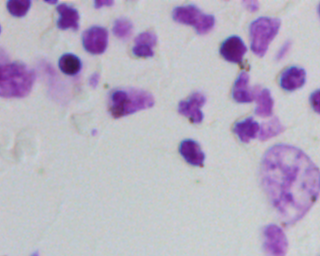

In [ ]:
img_f= train_files[250]
im= open_image(img_f)
im

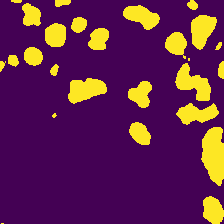

In [ ]:
image, mask_pred=predict_img_seg(im)
mask_pred

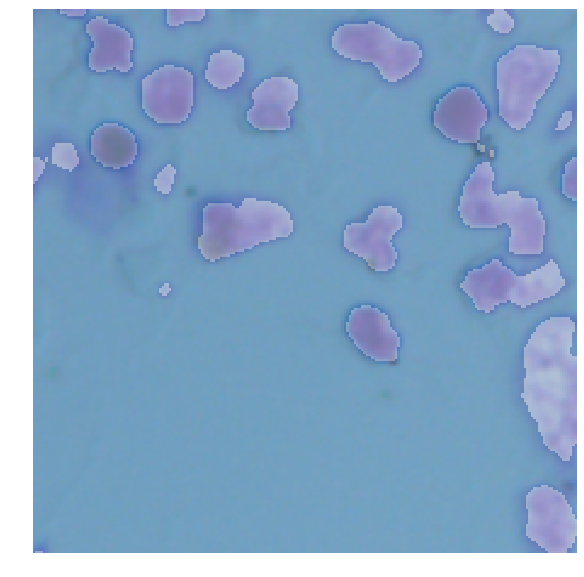

In [ ]:
image.show(y=mask_pred, figsize=(10,10), alpha=0.5)

In [ ]:
def show_mask(image: torch.Tensor, mask:torch.Tensor, alpha=0.5, cmap='tab20', figsize=(10,10)): 
    plt.figure(figsize=figsize)
    plt.imshow(image.permute(1,2,0), cmap='gray')
    plt.imshow(torch.squeeze(mask,dim=0), cmap=cmap, alpha=alpha)
    plt.grid(False)

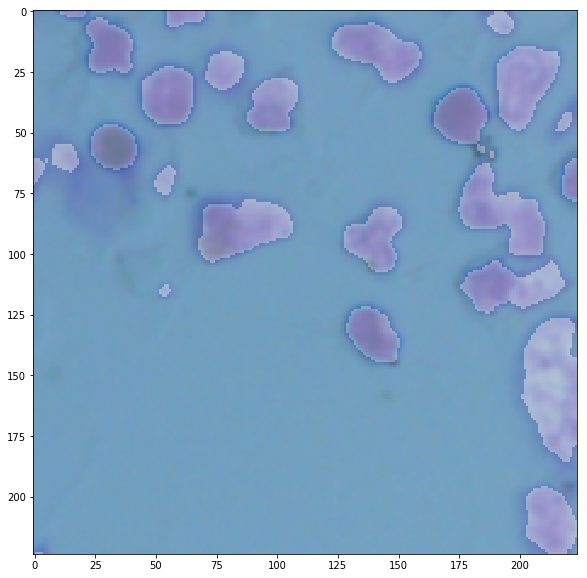

In [ ]:
show_mask(image.data, mask_pred.data)